# Treinamento, avaliação e impacto do modelo

Criação de um modelo para auxiliar a decisão de
qual oferta enviar para cada cliente. O modelo estima a probabilidade
de conversão de um cliente para uma determinada oferta e, a partir
dessas probabilidades, pode-se avaliar o impacto potencial em termos de
valor transacionado e eficiência das campanhas.

## Imports e carregamento do dataset

In [0]:
# !pip install lightgbm


In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, classification_report, log_loss

import lightgbm as lgb
import matplotlib.pyplot as plt
import itertools

In [0]:
df = spark.table("workspace.default.df_model2").toPandas()


In [0]:
df.display()

account_id offer_id n_offers_received n_offers_viewed target amount_transactioned channels discount_value duration min_value offer_type channel_web channel_email channel_mobile channel_social age credit_card_limit gender tenure problema_cadastro 0009655768c64bdeb2e877511632db8f 5a8bc65990b245e5a138643cd4eb9837 1 1 1 22.16 List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 33 72000.0 M 461 0 0009655768c64bdeb2e877511632db8f 3f207df678b143eea3cee63160fa8bed 1 1 0 null List(web, email, mobile) 0 4.0 0 informational 1 1 1 0 33 72000.0 M 461 0 0009655768c64bdeb2e877511632db8f f19421c1d4aa40978ebb69ca19b0e20d 1 1 1 8.57 List(web, email, mobile, social) 5 5.0 5 bogo 1 1 1 1 33 72000.0 M 461 0 0009655768c64bdeb2e877511632db8f fafdcd668e3743c1bb461111dcafc2a4 1 1 1 27.67 List(web, email, mobile, social) 2 10.0 10 discount 1 1 1 1 33 72000.0 M 461 0 0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1 0 1 69.2 List(web, email, mobile) 2 7.0 10 discount 1 1 1 0 33 72000.0 M 461 0 0011e0d4e6b944f998e987f904e8c1e5 3f207df678b143eea3cee63160fa8bed 1 1 1 13.49 List(web, email, mobile) 0 4.0 0 informational 1 1 1 0 40 57000.0 O 198 0 0011e0d4e6b944f998e987f904e8c1e5 2298d6c36e964ae4a3e7e9706d1fb8c2 1 1 1 11.93 List(web, email, mobile, social) 3 7.0 7 discount 1 1 1 1 40 57000.0 O 198 0 0011e0d4e6b944f998e987f904e8c1e5 5a8bc65990b245e5a138643cd4eb9837 1 1 0 null List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 40 57000.0 O 198 0 0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7 1 1 0 null List(web, email) 5 10.0 20 discount 1 1 0 0 40 57000.0 O 198 0 0011e0d4e6b944f998e987f904e8c1e5 9b98b8c7a33c4b65b9aebfe6a799e6d9 1 1 1 54.04 List(web, email, mobile) 5 7.0 5 bogo 1 1 1 0 40 57000.0 O 198 0 0020c2b971eb4e9188eac86d93036a77 fafdcd668e3743c1bb461111dcafc2a4 2 1 1 98.33 List(web, email, mobile, social) 2 10.0 10 discount 1 1 1 1 59 90000.0 F 874 0 0020c2b971eb4e9188eac86d93036a77 ae264e3637204a6fb9bb56bc8210ddfd 1 0 0 null List(email, mobile, social) 10 7.0 10 bogo 0 1 1 1 59 90000.0 F 874 0 0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0 1 1 0 null List(web, email, mobile, social) 10 5.0 10 bogo 1 1 1 1 59 90000.0 F 874 0 0020c2b971eb4e9188eac86d93036a77 5a8bc65990b245e5a138643cd4eb9837 1 1 1 98.52999999999999 List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 59 90000.0 F 874 0 0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2 1 1 1 46.59 List(web, email, mobile, social) 3 7.0 7 discount 1 1 1 1 24 60000.0 F 622 0 0020ccbbb6d84e358d3414a3ff76cffd f19421c1d4aa40978ebb69ca19b0e20d 1 1 1 14.53 List(web, email, mobile, social) 5 5.0 5 bogo 1 1 1 1 24 60000.0 F 622 0 0020ccbbb6d84e358d3414a3ff76cffd 5a8bc65990b245e5a138643cd4eb9837 1 1 1 58.87 List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 24 60000.0 F 622 0 0020ccbbb6d84e358d3414a3ff76cffd 9b98b8c7a33c4b65b9aebfe6a799e6d9 1 1 1 17.79 List(web, email, mobile) 5 7.0 5 bogo 1 1 1 0 24 60000.0 F 622 0 003d66b6608740288d6cc97a6903f4f0 5a8bc65990b245e5a138643cd4eb9837 1 1 1 2.51 List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 26 73000.0 F 400 0 003d66b6608740288d6cc97a6903f4f0 fafdcd668e3743c1bb461111dcafc2a4 2 2 1 13.09 List(web, email, mobile, social) 2 10.0 10 discount 1 1 1 1 26 73000.0 F 400 0 003d66b6608740288d6cc97a6903f4f0 3f207df678b143eea3cee63160fa8bed 1 1 1 11.79 List(web, email, mobile) 0 4.0 0 informational 1 1 1 0 26 73000.0 F 400 0 003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7 1 0 1 20.95 List(web, email) 5 10.0 20 discount 1 1 0 0 26 73000.0 F 400 0 00426fe3ffde4c6b9cb9ad6d077a13ea 5a8bc65990b245e5a138643cd4eb9837 1 1 1 30.92 List(email, mobile, social) 0 3.0 0 informational 0 1 1 1 19 65000.0 F 716 0 00426fe3ffde4c6b9cb9ad6d077a13ea fafdcd668e3743c1bb461111dcafc2a4 1 1 1 25.03 List(web, email, mobile, social) 2 10.0 10 discount 1 1 1 1 19 65000.0 F 716 0 00426fe3ffde4c6b9cb9ad6d077a13ea 0b1e1539f2cc45b7b9fa7c272da2e1d7 1 0 1 4.720000000000001 List(web, email) 

In [0]:
df["target"].value_counts(normalize=True)

# Não há desbalanceamento do target

target
1    0.779689
0    0.220311
Name: proportion, dtype: float64

In [0]:
df["gender"] = df["gender"].astype("category")
df["offer_type"] = df["offer_type"].astype("category")

y = df["target"]

features = [
    "n_offers_received",
    "n_offers_viewed",
    "discount_value",
    "duration",
    "min_value",
    "offer_type",
    "channel_email",
    "channel_mobile",
    "channel_web",
    "channel_social",
    "age",
    "credit_card_limit",
    "gender",
    "tenure"
]

X = df[features]

## Split do dataset e treinamento do modelo

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [0]:
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(
    X_train,
    y_train,
    categorical_feature= ['gender']
)

[LightGBM] [Info] Number of positive: 30139, number of negative: 8516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 38655, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.779692 -> initscore=1.263873
[LightGBM] [Info] Start training from score 1.263873


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               objective='binary', random_state=42, subsample=0.8)

## Tunning dos hiperparametros (trabalho futuro)

## Avaliação do modelo

In [0]:
# Criação de um baseline (a mesma probabilidade para todas as observações)

p_baseline = y_train.mean()

y_pred_train_baseline = np.full(len(y_train), p_baseline)
y_pred_test_baseline = np.full(len(y_test), p_baseline)

baseline_metrics = {
    "AUC_train": roc_auc_score(y_train, y_pred_train_baseline),
    "AUC_test": roc_auc_score(y_test, y_pred_test_baseline),
    "LogLoss_train": log_loss(y_train, y_pred_train_baseline),
    "LogLoss_test": log_loss(y_test, y_pred_test_baseline)
}

baseline_metrics

{'AUC_train': np.float64(0.5),
 'AUC_test': np.float64(0.5),
 'LogLoss_train': 0.5272973226802774,
 'LogLoss_test': 0.5273095154362555}

In [0]:
y_train_proba = lgb_model.predict_proba(X_train)[:, 1]
y_test_proba = lgb_model.predict_proba(X_test)[:, 1]

model_metrics = {
    "AUC_train": roc_auc_score(y_train, y_train_proba),
    "AUC_test": roc_auc_score(y_test, y_test_proba),
    "LogLoss_train": log_loss(y_train, y_train_proba),
    "LogLoss_test": log_loss(y_test, y_test_proba)
}

In [0]:
comparison_df = pd.DataFrame.from_dict(
    {
        "Baseline (prob. média)": baseline_metrics,
        "Modelo LGBM": model_metrics
    },
    orient="columns"
)

comparison_df.round(3)

Baseline (prob. média)  Modelo LGBM
AUC_train                       0.500        0.813
AUC_test                        0.500        0.752
LogLoss_train                   0.527        0.417
LogLoss_test                    0.527        0.456

In [0]:
prob_true_model, prob_pred_model = calibration_curve(
    y_test,
    y_test_proba,
    n_bins=10,
    strategy="uniform"
)

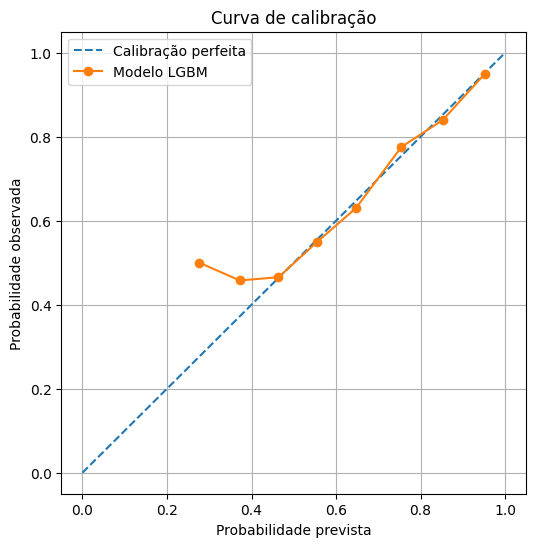

In [0]:
plt.figure(figsize=(6, 6))

# Linha ideal
plt.plot([0, 1], [0, 1], linestyle="--", label="Calibração perfeita")

# Modelo
plt.plot(
    prob_pred_model,
    prob_true_model,
    marker="o",
    label="Modelo LGBM"
)

plt.xlabel("Probabilidade prevista")
plt.ylabel("Probabilidade observada")
plt.title("Curva de calibração")
plt.legend()
plt.grid(True)
plt.show()

# A curva de calibração indica uma leve superestimação das probabilidades
# nas faixas mais baixas de score. No entanto, para probabilidades médias
# e altas — que são as mais relevantes para a priorização de ofertas —
# o modelo apresenta boa calibração.

## Feature importance

In [0]:
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": lgb_model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importance

feature  importance
13             tenure        2444
11  credit_card_limit        1953
10                age        1879
2      discount_value         446
1     n_offers_viewed         429
3            duration         388
12             gender         341
4           min_value         301
9      channel_social         296
0   n_offers_received         237
5          offer_type         146
8         channel_web         111
7      channel_mobile          29
6       channel_email           0

In [0]:
# TBD: SHAP Values

## Exemplo de aplicação e tomada de decisão

In [0]:
cliente = (
    X_test
    .sample(1, random_state=42)
    .drop(columns=[
        "offer_type",
        "min_value",
        "duration",
        "discount_value",
        "y",
        "prob_model"
    ], errors="ignore")
)

cliente

n_offers_received  n_offers_viewed  ...  gender  tenure
43029                  1                1  ...       F     823

[1 rows x 10 columns]

In [0]:
# Definir os valores do espaço de ofertas

offer_space = spark.table("workspace.default.df_model2") \
    .select("offer_type", "min_value", "duration", "discount_value") \
    .distinct() \
    .toPandas()


offer_space["offer_type"] = offer_space["offer_type"].astype("category")


In [0]:
offer_space

offer_type  min_value  duration  discount_value
0  informational          0       3.0               0
1  informational          0       4.0               0
2           bogo          5       5.0               5
3       discount         10      10.0               2
4       discount         10       7.0               2
5       discount          7       7.0               3
6       discount         20      10.0               5
7           bogo          5       7.0               5
8           bogo         10       7.0              10
9           bogo         10       5.0              10

In [0]:
cliente_offers = cliente.merge(offer_space, how="cross")

cliente_offers["prob_conversion"] = lgb_model.predict_proba(cliente_offers[features])[:, 1]

In [0]:
cliente_offers.sort_values(
    "prob_conversion",
    ascending=False
)

n_offers_received  n_offers_viewed  ...  discount_value  prob_conversion
3                  1                1  ...               2         0.889283
5                  1                1  ...               3         0.870658
4                  1                1  ...               2         0.866670
7                  1                1  ...               5         0.866163
8                  1                1  ...              10         0.865655
6                  1                1  ...               5         0.863041
2                  1                1  ...               5         0.848044
9                  1                1  ...              10         0.847480
1                  1                1  ...               0         0.809029
0                  1                1  ...               0         0.771531

[10 rows x 15 columns]

In [0]:
# Para esse cliente, a oferta com maior probabilidade de conversão seria:

cliente_offers \
    .sort_values("prob_conversion", ascending=False) \
    [["offer_type", "min_value", "duration", "discount_value"]] \
    .head(1)

offer_type  min_value  duration  discount_value
3   discount         10      10.0               2

## Impacto

In [0]:
df_impacto = df.groupby(['account_id'] + features, observed=True)['target'].max().reset_index()


In [0]:
df_impacto["key"] = 1
offer_space["key"] = 1

df_impacto = (
    df_impacto
    .drop(columns=[
        "offer_type",
        "min_value",
        "duration",
        "discount_value",
        "y",
        "prob_model"
    ], errors="ignore")
    .merge(offer_space, on="key")
    .drop(columns="key")
)


In [0]:
df_impacto["prob_conversion"] = (
    lgb_model.predict_proba(df_impacto[features])[:, 1]
)

best_offer_per_client_offer = (
    df_impacto
    .sort_values(
        ["account_id", "prob_conversion"],
        ascending=False
    )
    .groupby("account_id")
    .head(1)
)

conversao_modelo = best_offer_per_client_offer["prob_conversion"].mean()
print(conversao_modelo)
# Com o novo modelo em produção, teríamos uma conversão de 88.7%

0.8874641655330614


In [0]:
# Atualmente a conversão é de ~78%
conversao_atual = df['target'].mean()

print(conversao_atual)

0.7796892542827134


In [0]:
# avaliando impacto

(conversao_modelo-conversao_atual)/conversao_atual

np.float64(0.13822803207605716)